In [ ]:
!pip install indic-nlp-library
!pip install indicnlp
!pip install gensim
!pip install pyLDAvis
!pip install stanza

import gensim
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim
import stanza
stanza.download('te')
from gensim import corpora,models
from gensim.models import CoherenceModel

import re
# from indicnlp.tokenize import indic_tokenize
nlp = stanza.Pipeline('te')
import pandas as pd
from nltk import FreqDist
# from sklearn.feature_extraction.text import TfidfVectorizer

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: te (Telugu) ...
INFO:stanza:File exists: /root/stanza_resources/te/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: te (Telugu):
| Processor | Package    |
--------------------------
| tokenize  | mtg        |
| pos       | mtg_charlm |
| lemma     | identity   |
| depparse  | mtg_charlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
/usr/local/lib/python3.10/dist-packages/stanza/models/tokenization/trainer.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this m

# Reading the Dataset

In [ ]:
import pandas as pd

df = pd.read_excel('telugu_articles.xlsx')
articles = df['Content']
labels = df['Topic']
articles


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0       ‘‘మనం భిన్న భాషలు మాట్లాడుతున్నాం... మనందరినీ ...
1       ‘‘వేధింపుల గురించి బయటికొచ్చి ఫిర్యాదు చేస్తే ...
2       ‘కౌన్‌ బనేగా కరోడ్‌పతి’లో పవన్‌ కల్యాణ్‌కు సంబ...
3       ‘పఠించు, సృష్టించిన నీ ప్రభువు పేరుతో’ అన్న దై...
4       ‘ముక్కు, మోకాళ్లు ఎక్కడ పగలగొట్టుకున్నావురా.. ...
                              ...                        
1031    మంత్రి కొండా సురేఖ సినీ రంగంలోని వ్యక్తుల గురి...
1032    షాపింగ్‌ మాల్‌ ప్రారంభోత్సవంలో వేదిక కూలడంతో క...
1033    తానెందుకు 13 ఏళ్లపాటు ఒక్క సినిమాలో నటించలేదో ...
1034    భారాస కార్యానిర్వాహక అధ్యక్షుడు కేటీఆర్‌ను విమ...
1035    కేటీఆర్‌ తనపై రెచ్చగొట్టే వ్యాఖ్యలు చేయడంతో భా...
Name: Content, Length: 1036, dtype: object

# Normalizing the Text - Removing special chars and English chars

In [ ]:
import re

def normalize_text(word):
    word = re.sub(r"[\u200c:`,;'\"\\\n#%&*(){}\[\]=_\-+‘?!~]", "", word)
    word = re.sub(r"[A-Za-z0-9]", "", word)
    return word


# Apply the function to each row in 'articles'
df['cleaned_text'] = articles.apply(normalize_text)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df['cleaned_text']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0       మనం భిన్న భాషలు మాట్లాడుతున్నాం... మనందరినీ సి...
1       వేధింపుల గురించి బయటికొచ్చి ఫిర్యాదు చేస్తే చి...
2       కౌన్ బనేగా కరోడ్పతి’లో పవన్ కల్యాణ్కు సంబంధించ...
3       పఠించు సృష్టించిన నీ ప్రభువు పేరుతో’ అన్న దైవవ...
4       ముక్కు మోకాళ్లు ఎక్కడ పగలగొట్టుకున్నావురా.. కా...
                              ...                        
1031    మంత్రి కొండా సురేఖ సినీ రంగంలోని వ్యక్తుల గురి...
1032    షాపింగ్ మాల్ ప్రారంభోత్సవంలో వేదిక కూలడంతో కాం...
1033    తానెందుకు  ఏళ్లపాటు ఒక్క సినిమాలో నటించలేదో నట...
1034    భారాస కార్యానిర్వాహక అధ్యక్షుడు కేటీఆర్ను విమర...
1035    కేటీఆర్ తనపై రెచ్చగొట్టే వ్యాఖ్యలు చేయడంతో భావ...
Name: cleaned_text, Length: 1036, dtype: object

# Tokenizing the Sentence

In [ ]:
# from indicnlp.tokenize import indic_tokenize

# def tokenize_text(text):
#     tokens = indic_tokenize.trivial_tokenize(text, 'te')
#     return tokens

# df['tokenized_text'] = df['cleaned_text'].apply(tokenize_text)
def tokenize_text(text):
    tokens = text.split()
    return tokens

df['tokenized_text'] = df['cleaned_text'].apply(tokenize_text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df['tokenized_text']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0       [మనం, భిన్న, భాషలు, మాట్లాడుతున్నాం..., మనందరి...
1       [వేధింపుల, గురించి, బయటికొచ్చి, ఫిర్యాదు, చేస్...
2       [కౌన్, బనేగా, కరోడ్పతి’లో, పవన్, కల్యాణ్కు, సం...
3       [పఠించు, సృష్టించిన, నీ, ప్రభువు, పేరుతో’, అన్...
4       [ముక్కు, మోకాళ్లు, ఎక్కడ, పగలగొట్టుకున్నావురా....
                              ...                        
1031    [మంత్రి, కొండా, సురేఖ, సినీ, రంగంలోని, వ్యక్తు...
1032    [షాపింగ్, మాల్, ప్రారంభోత్సవంలో, వేదిక, కూలడంత...
1033    [తానెందుకు, ఏళ్లపాటు, ఒక్క, సినిమాలో, నటించలేద...
1034    [భారాస, కార్యానిర్వాహక, అధ్యక్షుడు, కేటీఆర్ను,...
1035    [కేటీఆర్, తనపై, రెచ్చగొట్టే, వ్యాఖ్యలు, చేయడంత...
Name: tokenized_text, Length: 1036, dtype: object

# Removing the most common stopwords

In [ ]:
telugu_stopwords = set([
  'ఈ', 'ఆ', 'ఒక','న',
    'నేను', 'మీరు', 'అతను', 'ఆమె', 'ఇది', 'అవి', 'నాకు', 'మీకు', 'అందరికి', 'ఎవరూ',
    'లో', 'పై', 'వద్ద', 'నుండి', 'తో', 'పైకి', 'కింద', 'మధ్య','మ', 'ఓ',
    'మరియు', 'కానీ', 'లేదా', 'కనుక', 'అందువల్ల', 'అంతేకాదు',
    'చాలా', 'కేవలం', 'ఎప్పుడూ', 'ఇప్పుడే', 'త్వరగా', 'నిశ్చయంగా',
    'ఉంది', 'ఉన్న', 'చేశారు', 'చేయాలి', 'కావాలి', 'కావడం',
    'ఏమిటి', 'ఎక్కడ', 'ఎందుకు', 'ఎలా', 'ఎవరు', 'ఏది', 'ఎప్పుడు',
    'కొంత', 'కొద్దిగా', 'చాలా', 'మొత్తం', 'కంటే',
    'ఈది', 'ఆది', 'అప్పుడు', 'ఇక్కడ', 'అక్కడ', 'ఎక్కడో', 'ఇప్పటి',
    'అవును', 'కాదు', 'ఇష్టం', 'నచ్చదు', 'వారు', 'మీ', 'మా',
    'చేయగలిగింది', 'గురించి', 'అందరూ', 'అందుబాటులో', 'అడగండి', 'అడగడం', 'అడ్డంగా', 'అనుగుణంగా',
    'అనుమతించు', 'అనుమతిస్తుంది', 'అయితే', 'ఇప్పటికే', 'ఉన్నారు', 'ఎక్కడైనా',
    'ఎవరైనా', 'ఎవరో', 'ఏ', 'ఏదైనా', 'ఏమైనప్పటికి', 'ఒకరు', 'కనిపిస్తాయి', 'కూడా',
    'గా', 'చుట్టూ', 'తగిన', 'తర్వాత', 'దాదాపు', 'దూరంగా', 'నిజంగా', 'ప్రకారం', 'ప్రక్కన',
    'మరొక', 'మళ్ళీ', 'మాత్రమే', 'మెచ్చుకో', 'వెంట', 'వేరుగా', 'వ్యతిరేకంగా', 'సంబంధం',
  'నుంచి', 'నా', 'తన','','ఉన్నాడు','చాలా','ప','పిలిచి','ఆయన', 'నీ','ఎంత','అత','త','|','ప',
  'అన్నా','కోసం','మీద','ముందు''అంత','గుండె','ఇప్పు','ఇలా','వుంది','ఉండటం',
  'పేరు','కొత్త', 'ఒకటి', 'అదే', 'మానవ','రెండో','లే','శ',
  'అతని', 'అంది','లేదు','జరిగింది','కూర్చుంది','అక్కడి','చేస్తున్నారు','ఇద్దరు','రావటం','ఉదయం','కాస్త','చేసింది',
  'వ...','న...','ముందు','మనసు', 'భార్య','జిల్లా', 'వాళ్ళు...','తప్ప','అన్నీ','కాబట్టి','స్వామి','ఎన్నో'
])

def remove_stopwords(tokens):
    return [word for word in tokens if word not in telugu_stopwords and len(word) > 3]

df['no_stopwords'] = df['tokenized_text'].apply(remove_stopwords)
df['no_stopwords']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0       [భిన్న, భాషలు, మాట్లాడుతున్నాం..., మనందరినీ, స...
1       [వేధింపుల, బయటికొచ్చి, ఫిర్యాదు, చేస్తే, చిత్ర...
2       [కౌన్, బనేగా, కరోడ్పతి’లో, పవన్, కల్యాణ్కు, సం...
3       [పఠించు, సృష్టించిన, ప్రభువు, పేరుతో’, అన్న, ద...
4       [ముక్కు, మోకాళ్లు, పగలగొట్టుకున్నావురా.., కాళ్...
                              ...                        
1031    [మంత్రి, కొండా, సురేఖ, సినీ, రంగంలోని, వ్యక్తు...
1032    [షాపింగ్, మాల్, ప్రారంభోత్సవంలో, వేదిక, కూలడంత...
1033    [తానెందుకు, ఏళ్లపాటు, ఒక్క, సినిమాలో, నటించలేద...
1034    [భారాస, కార్యానిర్వాహక, అధ్యక్షుడు, కేటీఆర్ను,...
1035    [కేటీఆర్, తనపై, రెచ్చగొట్టే, వ్యాఖ్యలు, చేయడంత...
Name: no_stopwords, Length: 1036, dtype: object

# Stemming the words
Example:- ఇంటికి (to the house) ---> ఇంటి (house)

In [ ]:
def te_stemmer(word):

    if(word.endswith("ల") == True or
      word.endswith("ఓ") == True):
        return word[:len(word)-1]

    if(word.endswith("డు") == True or
        word.endswith("ము") == True or
        word.endswith("వు") == True or
        word.endswith("లు") == True or
        word.endswith("ని") == True or
        word.endswith("ను") == True or
        word.endswith("చే") == True or
        word.endswith("తో") == True or
        word.endswith("కై") == True or
        word.endswith("లో") == True or
        word.endswith("కు") == True or
        word.endswith("కి") == True):
        return word[:len(word)-2]

    if(word.endswith("చేత") == True or
        word.endswith("తోడ") == True or
        word.endswith("వలన") == True or
        word.endswith("ఓరీ") == True or
        word.endswith("ఓయీ") == True or
        word.endswith("ఓసీ") == True):
        return word[:len(word)-3]

    if(word.endswith("లోపల") == True or
        word.endswith("కంటె") == True):
        return word[:len(word)-4]

    if(word.endswith("కొఱకు") == True or
        word.endswith("కొరకు") == True or
        word.endswith("పట్టి") == True or
        word.endswith("యొక్క") == True):
        return word[:len(word)-5]

    if(word.endswith("గూర్చి") == True):
        return word[:len(word)-6]

    if(word.endswith("గురించి") == True):
        return word[:len(word)-7]

    if(word.startswith("ఓ") == True):
        return word[1:]

    if(word.startswith("ఓయీ") == True or
      word.startswith("ఓరీ") == True or
      word.startswith("ఓసీ") == True):
        return word[3:]

    return word
df['stemmed_text'] = df['no_stopwords'].apply(
    lambda tokens: [te_stemmer(word) for word in tokens if te_stemmer(word) not in telugu_stopwords]
)
print(df[['no_stopwords', 'stemmed_text']].head())


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                        no_stopwords  \
0  [భిన్న, భాషలు, మాట్లాడుతున్నాం..., మనందరినీ, స...   
1  [వేధింపుల, బయటికొచ్చి, ఫిర్యాదు, చేస్తే, చిత్ర...   
2  [కౌన్, బనేగా, కరోడ్పతి’లో, పవన్, కల్యాణ్కు, సం...   
3  [పఠించు, సృష్టించిన, ప్రభువు, పేరుతో’, అన్న, ద...   
4  [ముక్కు, మోకాళ్లు, పగలగొట్టుకున్నావురా.., కాళ్...   

                                        stemmed_text  
0  [భిన్న, భాష, మాట్లాడుతున్నాం..., మనందరినీ, సిన...  
1  [వేధింపు, బయటికొచ్చి, ఫిర్యాదు, చేస్తే, చిత్ర,...  
2  [కౌన్, బనేగా, కరోడ్పతి’, పవన్, కల్యాణ్, సంబంధి...  
3  [పఠించు, సృష్టించిన, ప్రభు, పేరుతో’, అన్న, దైవ...  
4  [ముక్, మోకాళ్, పగలగొట్టుకున్నావురా.., కాళ్లూ, ...  


# Calculating Unique Words

In [ ]:
import pandas as pd
from nltk import FreqDist
import matplotlib.pyplot as plt

all_words = []
for text in df['stemmed_text']:
    all_words.extend(text)

fdist = FreqDist(all_words)
print("Total unique words in corpus: ", len(fdist))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total unique words in corpus:  7516


# Showing top 10 words

In [ ]:
k = 1000
top_k_words = fdist.most_common(k)
print(top_k_words)

[('మార్కెట్', 61), ('రిజిస్ట్రేషన్', 45), ('రెం', 36), ('సంస్థ', 36), ('ప్రభుత్వం', 34), ('ఉంది.', 33), ('విషయం', 32), ('జరిగిన', 31), ('ఇండియా', 29), ('చేసిన', 28), ('చేశారు.', 28), ('వారి', 28), ('మంత్రి', 27), ('తెలిపారు.', 27), ('నెల', 26), ('పోలీసు', 26), ('రోజు', 25), ('శాతం', 24), ('వెల్లడించింది.', 23), ('నగరం', 23), ('ముఖ్యమంత్రి', 23), ('నివేదిక', 22), ('మాజీ', 21), ('వైకాపా', 21), ('ఆగస్టు', 21), ('ఏడాది', 21), ('సమయం', 20), ('కేసు', 20), ('రియల్', 20), ('ఎస్టేట్', 20), ('నిర్మాణ', 20), ('గృహా', 20), ('జరిగాయి.', 20), ('పోలిస్తే', 20), ('తగ్గాయ', 20), ('నైట్', 20), ('ఫ్రాంక్', 20), ('స్థిరాస్తు', 20), ('విలువ', 20), ('కోట్లుగా', 20), ('ఇంటి', 19), ('లేదు.', 19), ('వ్యక్తి', 19), ('రాష్ట్ర', 19), ('తిరుమ', 19), ('కొనుగోలుదారుల', 19), ('ఆకట్టుకునేందు', 19), ('పథకాల', 19), ('ముందుకొస్తున్నాయి.', 19), ('స్తబ్దుగా', 19), ('చెల్లింపు', 19), ('వెసులుబాట్', 19), ('కల్పిస్తున్నాయి.', 19), ('పాటు', 18), ('చేసింది.', 18), ('సీఎం', 18), ('శ్రీవారి', 18), ('అంటే', 17), ('నన్', 17), ('రేవ

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]



texts_2 = []

for text in df['stemmed_text']:
    texts_2.append(keep_top_k_words(text))


texts_3 = []

new2oldindex_map = {}

old_index = 0
new_index = 0

for text in texts_2:
    if(len(text) >= 3):
        new2oldindex_map[new_index] = old_index
        texts_3.append(text)
        new_index += 1

    old_index += 1

print("Total docs before processing: ", len(df['stemmed_text']))
print("Total docs after processing: ", len(texts_3))

Total docs before processing:  1036
Total docs after processing:  690


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

id2word = corpora.Dictionary(texts_3)

texts = texts_3
corpus_bag = [id2word.doc2bow(text) for text in df['stemmed_text']]

tfidf = models.TfidfModel(corpus_bag)
corpus = tfidf[corpus_bag]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):

        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics=num_topics,
                                                   passes=50,
                                                   alpha="auto",
                                                   random_state=12)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=df['stemmed_text'], dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


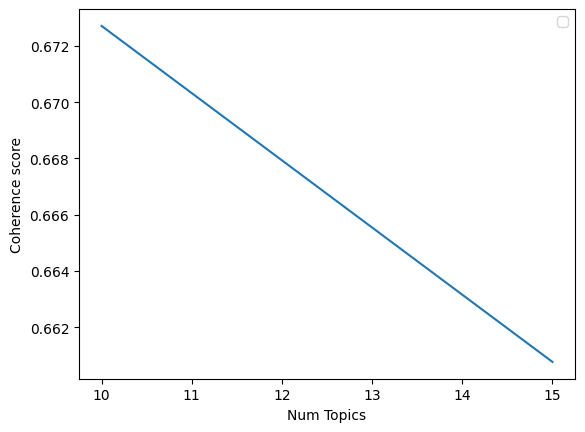

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

limit = 16
start = 10
step = 5
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df['stemmed_text'],
                                                       start=start, limit=limit, step=step)

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(["coherence_values"], loc='best')
plt.legend()


In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.6727
Num Topics = 15  has Coherence Value of 0.6608


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from pprint import pprint
optimal_model = model_list[0]
pprint(optimal_model.print_topics())

[(0,
  '0.016*"సరిగ్గా" + 0.013*"వుంటే" + 0.012*"సమయం" + 0.012*"అడిగింది" + '
  '0.010*"పెట్టి" + 0.008*"చెప్పింది." + 0.008*"భారత్" + 0.008*"విద్యా" + '
  '0.008*"విజయవాడ" + 0.008*"ఫొగాట్"'),
 (1,
  '0.019*"వాళ్ళు" + 0.014*"వుంది." + 0.012*"పెద్ద" + 0.010*"ప్రశ్న" + '
  '0.010*"కొండ" + 0.009*"నాకే" + 0.009*"వాటి" + 0.009*"మిస్టర్" + 0.009*"అగ్ర" '
  '+ 0.008*"వేసి"'),
 (2,
  '0.016*"తలుపు" + 0.015*"డాక్టర్" + 0.011*"ముఖ్యమంత్రి" + 0.011*"తల్లి" + '
  '0.010*"చంద్రబాబు" + 0.009*"రోజు" + 0.009*"చీకటి" + 0.008*"కోట్" + '
  '0.008*"అప్పటి" + 0.008*"కల్తీ"'),
 (3,
  '0.020*"ఫోన్" + 0.013*"దగ్గర" + 0.010*"బాధ" + 0.009*"చెప్పు" + 0.009*"...." '
  '+ 0.009*"బేబీ" + 0.008*"అప్పుడే" + 0.008*"సత్యం" + 0.008*"ఆలోచనల" + '
  '0.008*"అంటూ"'),
 (4,
  '0.020*"నువ్" + 0.016*"మంత్రి" + 0.014*"మాజీ" + 0.013*"అంది." + '
  '0.012*"రాష్ట్ర" + 0.010*"ప్రభుత్వం" + 0.009*"కాదు." + 0.009*"రేవంత్రెడ్డి" '
  '+ 0.009*"అంతా" + 0.009*"సీఎం"'),
 (5,
  '0.020*"కేసు" + 0.019*"పోలీసు" + 0.012*"అస" + 0.010*"భర్త" + 0.00

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.213953 -0.082970       1        1  15.374445
4     -0.054037  0.056707       2        1  11.929403
5     -0.037431  0.072321       3        1  11.030045
9      0.034082  0.046199       4        1  10.032218
6     -0.110617 -0.202188       5        1   9.756512
2      0.005933  0.029504       6        1   8.970315
8     -0.035465  0.017689       7        1   8.857135
1     -0.024106  0.009121       8        1   8.404227
0      0.015210  0.028971       9        1   8.121476
3     -0.007523  0.024645      10        1   7.524225, topic_info=              Term      Freq     Total Category  logprob  loglift
546       మార్కెట్  9.000000  9.000000  Default  30.0000  30.0000
807  రిజిస్ట్రేషన్  7.000000  7.000000  Default  29.0000  29.0000
562           కేసు  5.000000  5.000000  Default  28.0000  28.0000
67            నువ్  6.000000  6.000000  Default  27.0000  27.0000
64            ఫోన్  4.000000  4.000000  Default  26.0000  26.0000
..             ...       ...       ...      ...      ...      ...
814            వరద  0.995016  1.942315  Topic10  -5.0703   1.9182
0             అంటూ  1.230755  2.681372  Topic10  -4.8577   1.8083
621            నేల  0.923464  1.941607  Topic10  -5.1449   1.8439
737       శ్రీవారి  0.915678  4.330518  Topic10  -5.1534   1.0333
850           బాగా  0.820067  1.781194  Topic10  -5.2636   1.8114

[450 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
171      10  0.498000         ....
51        2  0.306317         అ...
51        4  0.306317         అ...
0         4  0.372943         అంటూ
0        10  0.372943         అంటూ
...     ...       ...          ...
235       2  0.628601      హరీశ్రా
554       5  0.525507  హెచ్చుతగ్గు
304       2  0.835597       హైడ్రా
337       1  0.305310    హైదరాబాద్
337       6  0.305310    హైదరాబాద్

[545 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 6, 10, 7, 3, 9, 2, 1, 4])

In [ ]:

new_sentence = """
ముంబై బాంద్రాలో ప్రాపర్టీలు కొనుగోలుకు బాలీవుడ్ నటుల మొగ్గు
ముంబై.. బాలీవుడ్ తారలకు చిరునామా. రియల్ ఎస్టేట్ రంగంలో రారాజుగా ఉన్న దేశ ఆర్థిక రాజధానిపై బాలీవుడ్ నటీనటులకు మక్కువ చాలా ఎక్కువ. అలాంటి ముంబైలో బాంద్రా అంటే మరింత క్రేజ్. చాలామంది బాలీవుడ్ నటనటులు బాంద్రాను తమ నివాస ప్రాంతంగా ఎంచుకున్నారు. ఇక్కడ చదరపు అడుగు ధర రూ.లక్షపైనే ఉందంటే ఆశ్చర్యపోనక్కర్లేదు. ఎందుకంటే తారాలోకం నుంచి ఉన్న డిమాండ్ అలాంటిది మరి. సల్మాన్ ఖాన్, షారుఖ్ ఖాన్, అమీర్ ఖాన్, రణబీర్ కపూర్, అలియా భట్, దీపికా పదుకొనే, త్రిప్తి దిమ్రీ, సంజయ్ దత్ వంటి బాలీవుడ్ తారలు బాంద్రాలో ప్రాపర్టీ కలిగి ఉన్నారు. దిలీప్ కుమార్, రిషి కపూర్ వంటి బాలీవుడ్ దిగ్గజాలు కూడా ఈ ప్రాంతంలో నివసించారు.
"""

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import numpy as np

def preprocess_text(text):
    text = normalize_text(text)

    tokens = tokenize_text(text)

    nouns = extract_nouns(tokens)

    nouns = [word for word in nouns if word not in telugu_stopwords]

    nouns = [te_stemmer(word) for word in nouns]

    nouns = [word for word in nouns if word not in telugu_stopwords]

    return nouns

def extract_nouns(tokens):
    """Extract nouns from tokenized text using Stanza."""

    sentence = " ".join(tokens)

    doc = nlp(sentence)

    nouns = [
        word.text for sentence in doc.sentences
        for word in sentence.words
        if word.pos == "NOUN" or word.pos == "PROPN"
    ]
    return nouns

preprocessed_tokens = preprocess_text(new_sentence)
print(preprocessed_tokens)

bow = id2word.doc2bow(preprocessed_tokens)

topics = sorted(optimal_model.get_document_topics(bow=bow), key=lambda x: x[1], reverse=True)

print("Top topic:", optimal_model.show_topic(topics[0][0]))
print("Associated %:", np.round(topics[0][1] * 100, 2), "%")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['ముంబై', 'బాంద్రా', 'ప్రాపర్టీ', 'కొనుగోలు', 'బాలీవుడ్', 'నటు', 'మొగ్గుముంబై', 'బాలీవుడ్', 'తారల', 'చిరునామా', 'రియల్', 'ఎస్టేట్', 'రంగం', 'రారాజుగా', 'దేశ', 'ఆర్థిక', 'రాజధానిపై', 'బాలీవుడ్', 'నటీనటుల', 'మక్కువ', 'ముంబై', 'బాంద్రా', 'క్రేజ్', 'బాలీవుడ్', 'నటనటు', 'బాంద్రా', 'నివాస', 'ప్రాంతంగా', 'చదరపు', 'అడుగు', 'ధర', 'రూ.లక్షపైనే', 'తారాలోకం', 'డిమాండ్', 'సల్మాన్', 'ఖాన్', 'షారుఖ్', 'ఖాన్', 'అమీర్', 'ఖాన్', 'రణబీర్', 'కపూర్', 'అలియా', 'భట్', 'దీపికా', 'త్రిప్తి', 'దిమ్రీ', 'సంజయ్', 'దత్', 'బాలీవుడ్', 'తార', 'బాంద్రా', 'ప్రాపర్టీ', 'దిలీప్', 'కుమార్', 'రిషి', 'కపూర్', 'బాలీవుడ్', 'దిగ్గజా', 'ప్రాంతం']
Top topic: [('భారత', 0.016287947), ('నటు', 0.015792396), ('అతడి', 0.0128876055), ('ముఖం', 0.012544139), ('రెం', 0.011880162), ('సినీ', 0.011226169), ('తెలిపారు.', 0.009688891), ('సినిమా', 0.009607312), ('చేశారు.', 0.00948975), ('తాజాగా', 0.009335457)]
Associated %: 51.82 %
